In [53]:
import os
import cv2
import keras.callbacks
from PIL import Image
import numpy as np
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib import pyplot as plt
import random
from keras import backend as K
from keras.models import load_model
import gradio as gr

In [3]:
# Create IoU (Jaccard coefision)
def jaccard_coef(y_true, y_pred):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
    return final_coef_value

In [5]:
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [6]:
# Generating loss function
# total_loss = (dice_loss + (1 * focal_loss)
weights = [0.166, 0.166, 0.166, 0.166, 0.166, 0.166]
dice_loss = sm.losses.DiceLoss(class_weights=weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [10]:
#load model
satellite_model = load_model(
    'C:/Users/dimas.perceka/OneDrive - Koltiva/Desktop/Belajar/Deep Learning/Rob_cole/j_planet-segmentation-unet/j_planet-segmentation-unet/satellite_segmentation_full.h5',
    custom_objects=({'dice_loss_plus_1focal_loss' : total_loss, 'jaccard_coef': jaccard_coef})
)

In [11]:
# Membaca gambar
image = Image.open('C:/Users/dimas.perceka/OneDrive - Koltiva/Desktop/Belajar/Deep Learning/Rob_cole/j_planet-segmentation-unet/j_planet-segmentation-unet/sentinel2_imagery.tif')

# Mereshape gambar ke (None, 256, 256, 3)
image = image.resize((256, 256))
image = np.array(image)
image_rgb = image[:, :, :3]
image_rgb = np.expand_dims(image_rgb,0)

In [13]:
prediction_sentinel = satellite_model.predict(image_rgb)

1/1 [==============================] - 0s 78ms/step


In [14]:
predicted_image_sentinel = np.argmax(prediction_sentinel, axis=3)
predicted_image_sentinel = predicted_image_sentinel[0,:,:]

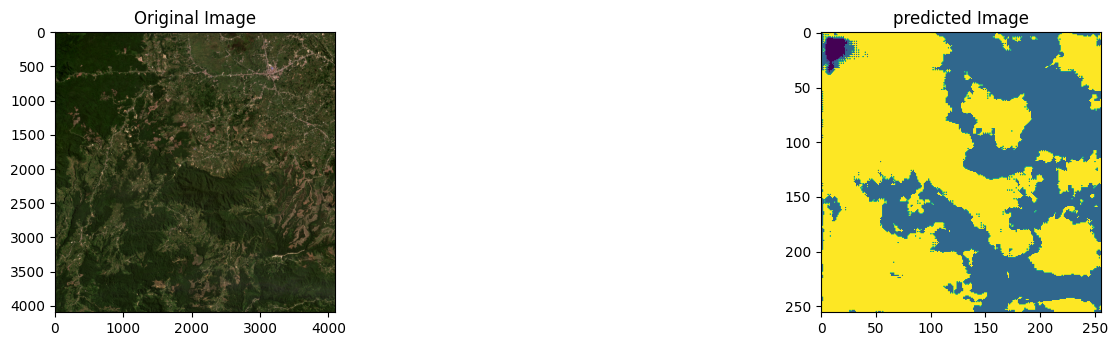

In [15]:
plt.figure(figsize=(14,8))

plt.subplot(231)
plt.title("Original Image")
plt.imshow(Image.open('C:/Users/dimas.perceka/OneDrive - Koltiva/Desktop/Belajar/Deep Learning/Rob_cole/j_planet-segmentation-unet/j_planet-segmentation-unet/sentinel2_imagery.tif'))

plt.subplot(233)
plt.title("predicted Image")
plt.imshow(predicted_image_sentinel)

## Create application

In [54]:
def process_input_image(image_source):
    image_rgb = np.expand_dims(image_source,0)

    prediction_sentinel = satellite_model.predict(image_rgb)
    predicted_image_sentinel = np.argmax(prediction_sentinel, axis=3)
    predicted_image_sentinel = predicted_image_sentinel[0,:,:]
    predicted_image_sentinel = predicted_image_sentinel * 50

    return "Predicted Mask Image", predicted_image_sentinel

In [55]:
segmentation_app = gr.Blocks()

In [56]:
with segmentation_app:
    gr.Markdown("Image Processing Application UI with Gradio")
    with gr.Tabs():
        with gr.TabItem("Select your image"):
            with gr.Row():
                with gr.Column():
                    img_source = gr.Image(label="Please select source Image", shape=(256,256))
                    source_image_loader = gr.Button("Load above Image")
                with gr.Column():
                    output_label = gr.Label(label="Image Info")
                    img_output = gr.Image(label="Image Output")
            source_image_loader.click(
                process_input_image,
                [
                    img_source
                ],
                [
                    output_label,
                    img_output
                ]
            )

In [57]:
segmentation_app.launch()

Running on local URL:  http://127.0.0.1:7867

To create a public link, set `share=True` in `launch()`.
